# 이미지 이상탐지모델(GAN)

- 딥러닝 기술이 유용하게 사용될 수 있는 대표적인 사례로 바로 이상감지(Anomaly Detection)를 꼽을 수 있습니다. 혹시라도 위험한 물품이 포함되어 있지 않을까 24시간 사람이 뚫어져라 모니터를 쳐다보고 있어야만 하는 고된 일을 인공지능이 대신 정확하게 수행해 줄 수 있다면 좋겠죠? 이런 과제는 실제로 공항, 항만, 주요 군사시설 등에서 매우 관심을 가지고 진행하고 있답니다. 그런데 이런 이상감지 모델로 GAN 기술이 유용하게 활용되고 있다고 합니다.

- 왜 그럴까요? 그냥 쉽게 생각할 수 있는 지도학습(supervised learning)으로는 어려울까요? 네 그렇습니다. 이상감지 태스크의 경우, 정상(Normal) 상황에 대한 데이터는 아주 풍부하게 얻을 수 있지만, 이상(Anomaly) 상황에 대한 데이터는 매우 부족할 뿐 아니라 사실상 모든 케이스의 이상 상황을 정의할 수조차 없기 때문입니다. 이 때 GAN이 사용된다면 이상(Anomaly) 데이터가 충분하지 않은 경우에도 꽤 쓸만한 이상감지 성능을 발휘하는 모델을 만들 수 있다고 합니다.

## 학습목표
- 이상(Anomaly) 데이터가 부족한 상황에서 GAN을 이용해 이미지 이상감지 모델을 구축하는 논리를 파악한다.
- Skip-GANomaly 모델 및 Loss 함수를 구현해 본다.
- 간단한 데이터셋을 이용해 Skip-GANomaly 의 이상감지 효과를 파악해 본다.

## 학습 목차
- Anomaly Detection with GAN
- GANomaly
- Skip-GANomaly
- 데이터셋 구성
- 모델과 Loss함수 구성
- 모델 학습과 평가

## 평가 루브릭

- 아래의 기준을 바탕으로 프로젝트를 평가합니다.

###  평가문항	상세기준
1. Anomaly Detection 태스크 특성에 맞도록 데이터셋 가공이 진행되었다.: 개구리 클래스가 배제되어 테스트셋에만 반영되는 로직이 구현되었다.
2. Skip-GANomaly 모델이 정상적으로 구현되었다.: 모델 학습 및 테스트가 원활하게 진행되었다.
3. 이상감지 수행 결과가 체계적으로 시각화되었다. : 정상-이상 데이터의 anomaly score 분포 시각화, 테스트셋 이상감지 정확도(%), 적절한 threshold에 따른 이상 감지율 계산, 이상감지 성공실패사례 제시가 진행되었다.

# ★ 프로젝트: 개구리 이상감지 경고 시스템 (CIFAR-10) ★ 

- 이번 프로젝트는 CIFAR-10 데이터셋에 대해 진행해 보겠습니다. 
- CIFAR-10의 10가지 클래스 중 개구리 라벨을 이상 데이터로 처리하는 모델입니다. 
- 혹시 개구리가 출현할 경우 이를 감지하여 이상감지 경고를 발생시키는 개구리 감지 모델이라고 할 수 있겠습니다.

# 데이터셋 구성(Fashion-MNIST)

- 지금부터는 Skip-GANomaly 모델을 실제로 구현하는 과정을 진행하려고 합니다. 
- 이런 이상감지 모델을 학습할 때 쉽게 사용하는 데이터 구성은 MNIST 같이 잘 알려진 데이터셋에서 특정 클래스를 이상 데이터로 활용하는 방식입니다. 
- 예를 들어 0으로 라벨링된 모든 이미지를 훈련 데이터에서 제거하고 1~9로만 학습을 시킨 후 테스트 데이터를 0을 포함한(이상 데이터를 포함한) 형태로 구성하여 이상감지 성능을 평가하는 방식입니다.

- CIFAR-10에서 6번 라벨이 개구리(Frog)입니다. 개구리를 제거하고 나머지 클래스로 구성된 CIFAR-10 데이터를 정상 데이터로 삼아볼 생각입니다.

- 말하자면, 우리의 모델은 개구리는 보도 듣도 못하였으며, 개구리가 나타나면 매우 특이한 상황이라고 가정하는 것입니다.

In [1]:
import tensorflow as tf

from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from scipy.interpolate import interp1d
from inspect import signature
from scipy.optimize import brentq

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os

import PIL
from tensorflow.keras import layers
import time
from scipy.stats import norm

from IPython import display
import warnings
warnings.filterwarnings("ignore")

# 이상감지용 데이터셋 구축

## 개구리 데이터를 학습데이터셋에서 제외하여 테스트 데이터셋에 포함

- 위에서 언급한 대로 학습/테스트 데이터셋을 구축해 보겠습니다.

- CIFAR-10 이미지를 사용하도록 하겠습니다. 

    - 3채널 color 데이터셋입니다. Convolution 연산의 reshape 과정이 필요없습니다. 
    - 데이터 이미지 사이즈는 32 X 32이므로 바로 Unet 구조 활용이 가능합니다.

In [2]:
(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.cifar10.load_data()

from PIL import Image

print(train_data.shape)
print(test_data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


- 학습에 사용할 train_x의 이미지를 [-1, 1]로 정규화합니다.
- 로드한 CIFAR-10 학습 데이터를 시각화를 통해 확인해 봅시다.

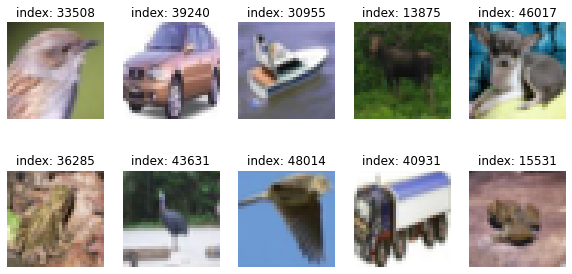

In [3]:
plt.figure(figsize=(10, 5))

for i in range(10):
    rn = np.random.randint(len(train_data))
    plt.subplot(2, 5, i+1)
    plt.imshow(train_data[rn])
    plt.title(f'index: {rn}')
    plt.axis('off')
plt.show()

In [4]:
# 이미지를 [-1, 1]로 정규화합니다

train_data = (train_data - 127.5) / 127.5
test_data = (test_data - 127.5) / 127.5

# float32 데이터 타입 변환
train_data = train_data.reshape(train_data.shape[0], 32, 32, 3).astype('float32')
test_data = test_data.reshape(test_data.shape[0], 32, 32, 3).astype('float32')

- 위에서 설명한 대로 이상 데이터로 선정된 6번 라벨(Frog) 데이터를 제외하도록 하겠습니다.

In [6]:
def set_labels(labels):
    new_t_labels = []
    for old_label in labels:
        if old_label == 6:   # Frog: 6
            new_t_labels.append([0])  # Frog를 이상치로 처리
        else:
            new_t_labels.append([1])  # 그 외의 경우는 정상치
             
    return np.array(new_t_labels)

In [7]:
bol_train_labels = set_labels(train_labels)
bol_test_labels = set_labels(test_labels)

In [8]:
normal_data = []
normal_labels = []
anomaly_data = []
anomaly_labels = []
for data, label in zip(train_data, bol_train_labels):
    if label == 0:
        anomaly_data.append(data)
        anomaly_labels.append(label)
    else:
        normal_data.append(data)
        normal_labels.append(label)
        
normal_data = np.array(normal_data)
normal_labels = np.array(normal_labels)
anomaly_data = np.array(anomaly_data)
anomaly_labels = np.array(anomaly_labels)

In [9]:
print(normal_data.shape, normal_labels.shape)
print(anomaly_data.shape, anomaly_labels.shape)

(45000, 32, 32, 3) (45000, 1)
(5000, 32, 32, 3) (5000, 1)


In [10]:
train_data = normal_data
bol_train_labels = normal_labels
test_data = tf.concat([test_data, anomaly_data], 0)
bol_test_labels = tf.concat([bol_test_labels, anomaly_labels], 0)

In [11]:
print(train_data.shape)
print(test_data.shape)

(45000, 32, 32, 3)
(15000, 32, 32, 3)


In [12]:
print(bol_train_labels.shape)
print(bol_test_labels.shape)

(45000, 1)
(15000, 1)


- 어떻습니까? 50000건의 훈련데이터 중 5000건이 제외되어 10000건의 테스트 데이터에 추가되었습니다. 계산이 맞아떨어지나요?

- 데이터셋이 정확하게 구성되었는지 좀더 검증해 보겠습니다.

In [13]:
for label in bol_train_labels:
    if label == 0:
        print(label)
print("Done")

Done


- 이제 데이터셋을 구성하고 label을 검증해 보겠습니다.

- 훈련 데이터셋에는 라벨이 1인 데이터만 존재하고, 테스트 데이터에는 0과 1이 섞여 있어야 합니다.

In [14]:
BUFFER_SIZE = 10000
BATCH_SIZE = 8

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, bol_train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, bol_test_labels))
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [15]:
for data, label in train_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)


In [16]:
for data, label in test_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]], shape=(8, 1), dtype=int64)


# Skip-GANomaly 모델의 구현


![title](Skip-GANomaly1.png)


![title](Skip-GANomaly2.png)

# 모델과 Loss함수 구성

## Generator
- 이제 본격적으로 모델을 구성해 보겠습니다. Generator는 그동안 자주 다루었을 UNet 구조를 따릅니다.

In [17]:
class Conv_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_block, self).__init__()
        self.conv_layer = tf.keras.Sequential([
            layers.Conv2D(num_filters, 3, strides=2, padding='same', use_bias=False,
                          kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
        ])
        
    def call(self, inputs, training=False):
        outputs = self.conv_layer(inputs)
        
        return outputs

In [18]:
class Conv_T_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_T_block, self).__init__()
        self.conv_T_layer = tf.keras.Sequential([
            layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same', use_bias=False,
                                   kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])
        
    def call(self, inputs, concat, training=False):
        upsample = self.conv_T_layer(inputs)
        outputs = tf.concat([upsample, concat], -1)
        
        return outputs

In [19]:
class Generator(tf.keras.Model):
    def __init__(self, num_output_channel=3):
        super(Generator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(512) # 1
        
        self.decoder_4 = Conv_T_block(512) # 2
        self.decoder_3 = Conv_T_block(256) # 4
        self.decoder_2 = Conv_T_block(128) # 8
        self.decoder_1 = Conv_T_block(64) # 16
        
        self.output_layer = layers.Conv2DTranspose(num_output_channel, 1, strides=2, padding='same', use_bias=False, # 32
                                                   kernel_initializer=tf.random_normal_initializer(0., 0.02))
                
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # gen
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        de_4 = self.decoder_4(center, en_4)
        de_3 = self.decoder_3(de_4, en_3)
        de_2 = self.decoder_2(de_3, en_2)
        de_1 = self.decoder_1(de_2, en_1)
        
        outputs = self.output_layer(de_1)
        
        return outputs

# Discriminator
- Discriminator도 Generator처럼 Conv_block을 활용하며, 최종적으로 sigmoid를 거쳐 0~1 사이의 숫자를 리턴합니다.

In [20]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(100) # 1
        
        self.outputs = layers.Conv2D(1, 3, strides=1, padding='same',
                                          use_bias=False, activation='sigmoid')
    
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # dis
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        outputs = self.outputs(center)
        
        return outputs, center

# 전체 모델 구성
- Generator와 Discriminator을 합쳐 전체 모델을 구성해 봅시다.

In [21]:
generator = Generator(num_output_channel=3)  # Generator가 32X32X3 짜리 이미지를 생성해야 합니다. 
discriminator = Discriminator()

# Loss 함수
- GAN 모델의 핵심은 Loss 함수의 구성방법에 달려 있다고 해도 과언이 아닙니다. Skip-GANomaly는 이전 모델들과 달리 일반적인 GAN의 학습 절차와 같은 형태의 Loss 구성이 진행됩니다.

In [22]:
l2_loss = tf.keras.losses.MeanSquaredError()
l1_loss = tf.keras.losses.MeanAbsoluteError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [23]:
def discriminator_loss(pred_real, pred_fake):
    real_loss = cross_entropy(tf.ones_like(pred_real), pred_real)
    fake_loss = cross_entropy(tf.zeros_like(pred_fake), pred_fake)
    
    total_dis_loss = (real_loss + fake_loss) * 0.5
    
    return total_dis_loss

- 아래 Generator Loss에는 이전 스텝에서 설명했던 Skip-GANomaly의 주요 loss 함수들이 포함되어 있음을 주목해 주세요.

In [24]:
def generator_loss(real_output, fake_output, input_data, gen_data, latent_first, latent_sec):
    w_adv = 1.
    w_context = 40.
    w_encoder = 1.
    
    adv_loss = cross_entropy(real_output, fake_output)
    context_loss = l1_loss(input_data, gen_data)
    encoder_loss = l2_loss(latent_first, latent_sec)
    
    total_gen_loss = w_adv * adv_loss + \
                     w_context * context_loss + \
                     w_encoder * encoder_loss
    
    return total_gen_loss

In [25]:
# Optimizer 설정
generator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)

# 모델의 학습과 검증

# 모델 학습과 평가
## Model Train
- 이제 본격적으로 모델을 학습해 보겠습니다. 총 25Epoch 대략 1시간 정도 소요될 수 있습니다.

In [26]:
def train_step(images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(images, training=True)
        
        pred_real, feat_real = discriminator(images, training=True)
        pred_fake, feat_fake = discriminator(generated_images, training=True)

        gen_loss = generator_loss(pred_real, pred_fake,
                                  images, generated_images,
                                  feat_real, feat_fake)

        disc_loss = discriminator_loss(pred_real, pred_fake)        

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [27]:
checkpoint_path = os.path.join(os.getenv('HOME'),'aiffel/GANomaly/ganomaly_skip_no_norm/ckpt1')

if not os.path.isdir(checkpoint_path):
    os.makedirs(checkpoint_path)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

- 총 25Epoch 를 수행하는데 1시간 이상 소요될 수 있습니다.

In [28]:
max_epochs = 25
steps = 0

for epoch in range(max_epochs):
    start = time.time()

    for images, labels in train_dataset:
        steps += 1
        gen_loss, disc_loss = train_step(images)
        
        if steps % 100 == 0:
            print ('Steps : {}, \t Total Gen Loss : {}, \t Total Dis Loss : {}'.format(steps, gen_loss.numpy(), disc_loss.numpy()))
        
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_path)
        
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

Steps : 100, 	 Total Gen Loss : 14.313623428344727, 	 Total Dis Loss : 0.7018235921859741
Steps : 200, 	 Total Gen Loss : 14.977291107177734, 	 Total Dis Loss : 0.6398770809173584
Steps : 300, 	 Total Gen Loss : 12.386713981628418, 	 Total Dis Loss : 0.535588800907135
Steps : 400, 	 Total Gen Loss : 17.506315231323242, 	 Total Dis Loss : 0.3149919807910919
Steps : 500, 	 Total Gen Loss : 16.563995361328125, 	 Total Dis Loss : 0.17589375376701355
Steps : 600, 	 Total Gen Loss : 20.432497024536133, 	 Total Dis Loss : 0.2681710124015808
Steps : 700, 	 Total Gen Loss : 16.349384307861328, 	 Total Dis Loss : 0.0801103338599205
Steps : 800, 	 Total Gen Loss : 18.181903839111328, 	 Total Dis Loss : 0.056031644344329834
Steps : 900, 	 Total Gen Loss : 17.390636444091797, 	 Total Dis Loss : 0.13699772953987122
Steps : 1000, 	 Total Gen Loss : 18.663225173950195, 	 Total Dis Loss : 0.29011446237564087
Steps : 1100, 	 Total Gen Loss : 20.830421447753906, 	 Total Dis Loss : 0.0272382702678442
Step

Steps : 9000, 	 Total Gen Loss : 25.380373001098633, 	 Total Dis Loss : 0.0011436908971518278
Steps : 9100, 	 Total Gen Loss : 21.424484252929688, 	 Total Dis Loss : 0.002478247042745352
Steps : 9200, 	 Total Gen Loss : 20.34758186340332, 	 Total Dis Loss : 0.005473420023918152
Steps : 9300, 	 Total Gen Loss : 19.937694549560547, 	 Total Dis Loss : 0.003217320889234543
Steps : 9400, 	 Total Gen Loss : 19.21841049194336, 	 Total Dis Loss : 0.009066691622138023
Steps : 9500, 	 Total Gen Loss : 23.933176040649414, 	 Total Dis Loss : 0.0015853820368647575
Steps : 9600, 	 Total Gen Loss : 21.520015716552734, 	 Total Dis Loss : 0.0014084369176998734
Steps : 9700, 	 Total Gen Loss : 23.588977813720703, 	 Total Dis Loss : 0.0008955857483670115
Steps : 9800, 	 Total Gen Loss : 24.506906509399414, 	 Total Dis Loss : 0.0009641604265198112
Steps : 9900, 	 Total Gen Loss : 23.3546199798584, 	 Total Dis Loss : 0.0011049448512494564
Steps : 10000, 	 Total Gen Loss : 21.726804733276367, 	 Total Dis Lo

Steps : 17700, 	 Total Gen Loss : 25.724586486816406, 	 Total Dis Loss : 0.0013633323833346367
Steps : 17800, 	 Total Gen Loss : 26.798978805541992, 	 Total Dis Loss : 0.0003705396084114909
Steps : 17900, 	 Total Gen Loss : 22.588897705078125, 	 Total Dis Loss : 0.00183590454980731
Steps : 18000, 	 Total Gen Loss : 22.49734878540039, 	 Total Dis Loss : 0.0005611561937257648
Steps : 18100, 	 Total Gen Loss : 26.4140625, 	 Total Dis Loss : 0.0004425010411068797
Steps : 18200, 	 Total Gen Loss : 24.706207275390625, 	 Total Dis Loss : 0.0005780404317192733
Steps : 18300, 	 Total Gen Loss : 24.74075698852539, 	 Total Dis Loss : 0.0012782306876033545
Steps : 18400, 	 Total Gen Loss : 24.150753021240234, 	 Total Dis Loss : 0.0013764696195721626
Steps : 18500, 	 Total Gen Loss : 24.544845581054688, 	 Total Dis Loss : 0.0004909060662612319
Steps : 18600, 	 Total Gen Loss : 26.108715057373047, 	 Total Dis Loss : 0.00019644918211270124
Steps : 18700, 	 Total Gen Loss : 27.134265899658203, 	 Total

Steps : 26400, 	 Total Gen Loss : 26.100521087646484, 	 Total Dis Loss : 0.0018775511998683214
Steps : 26500, 	 Total Gen Loss : 30.35918617248535, 	 Total Dis Loss : 0.03422648459672928
Steps : 26600, 	 Total Gen Loss : 26.602954864501953, 	 Total Dis Loss : 0.00043855200055986643
Steps : 26700, 	 Total Gen Loss : 24.8847599029541, 	 Total Dis Loss : 0.0329446941614151
Steps : 26800, 	 Total Gen Loss : 27.695165634155273, 	 Total Dis Loss : 0.0009725734125822783
Steps : 26900, 	 Total Gen Loss : 28.988088607788086, 	 Total Dis Loss : 0.002723292214795947
Steps : 27000, 	 Total Gen Loss : 25.635316848754883, 	 Total Dis Loss : 0.0017817754996940494
Steps : 27100, 	 Total Gen Loss : 25.116823196411133, 	 Total Dis Loss : 0.0054518794640898705
Steps : 27200, 	 Total Gen Loss : 24.685710906982422, 	 Total Dis Loss : 0.002139149932190776
Steps : 27300, 	 Total Gen Loss : 30.226160049438477, 	 Total Dis Loss : 0.0008011008030734956
Steps : 27400, 	 Total Gen Loss : 32.42326736450195, 	 Tota

Steps : 35100, 	 Total Gen Loss : 26.305387496948242, 	 Total Dis Loss : 0.00022861844627186656
Steps : 35200, 	 Total Gen Loss : 22.52717399597168, 	 Total Dis Loss : 0.0003082270850427449
Steps : 35300, 	 Total Gen Loss : 28.591697692871094, 	 Total Dis Loss : 0.0001731092343106866
Steps : 35400, 	 Total Gen Loss : 26.94941520690918, 	 Total Dis Loss : 0.0005431465106084943
Steps : 35500, 	 Total Gen Loss : 26.011672973632812, 	 Total Dis Loss : 0.0007620514370501041
Steps : 35600, 	 Total Gen Loss : 25.15285873413086, 	 Total Dis Loss : 0.00018829107284545898
Steps : 35700, 	 Total Gen Loss : 26.564132690429688, 	 Total Dis Loss : 0.0011070292675867677
Steps : 35800, 	 Total Gen Loss : 27.739219665527344, 	 Total Dis Loss : 0.0005703965434804559
Steps : 35900, 	 Total Gen Loss : 28.958759307861328, 	 Total Dis Loss : 0.0007732524536550045
Steps : 36000, 	 Total Gen Loss : 27.4603271484375, 	 Total Dis Loss : 0.0054631540551781654
Steps : 36100, 	 Total Gen Loss : 24.055461883544922,

Steps : 43800, 	 Total Gen Loss : 26.33578872680664, 	 Total Dis Loss : 0.0005664181080646813
Steps : 43900, 	 Total Gen Loss : 28.7326717376709, 	 Total Dis Loss : 0.00019209226593375206
Steps : 44000, 	 Total Gen Loss : 29.695560455322266, 	 Total Dis Loss : 0.0002855970524251461
Steps : 44100, 	 Total Gen Loss : 29.16278648376465, 	 Total Dis Loss : 0.00034167018020525575
Steps : 44200, 	 Total Gen Loss : 27.22183609008789, 	 Total Dis Loss : 0.001742927823215723
Steps : 44300, 	 Total Gen Loss : 26.077993392944336, 	 Total Dis Loss : 0.0005101317074149847
Steps : 44400, 	 Total Gen Loss : 25.10308265686035, 	 Total Dis Loss : 0.0026698021683841944
Steps : 44500, 	 Total Gen Loss : 26.81296157836914, 	 Total Dis Loss : 0.0002499778347555548
Steps : 44600, 	 Total Gen Loss : 27.945276260375977, 	 Total Dis Loss : 0.00029068876756355166
Steps : 44700, 	 Total Gen Loss : 26.727954864501953, 	 Total Dis Loss : 0.0008640224696137011
Steps : 44800, 	 Total Gen Loss : 25.532899856567383, 	

Steps : 52400, 	 Total Gen Loss : 27.311729431152344, 	 Total Dis Loss : 0.0005883705453015864
Steps : 52500, 	 Total Gen Loss : 25.06689453125, 	 Total Dis Loss : 0.0002714730508159846
Steps : 52600, 	 Total Gen Loss : 29.135051727294922, 	 Total Dis Loss : 0.00021089005167596042
Steps : 52700, 	 Total Gen Loss : 26.151962280273438, 	 Total Dis Loss : 0.013136306777596474
Steps : 52800, 	 Total Gen Loss : 26.037080764770508, 	 Total Dis Loss : 0.00010655514779500663
Steps : 52900, 	 Total Gen Loss : 23.92413330078125, 	 Total Dis Loss : 0.00047175417421385646
Steps : 53000, 	 Total Gen Loss : 29.362899780273438, 	 Total Dis Loss : 0.0009130330290645361
Steps : 53100, 	 Total Gen Loss : 28.695213317871094, 	 Total Dis Loss : 0.01080428808927536
Steps : 53200, 	 Total Gen Loss : 26.033363342285156, 	 Total Dis Loss : 0.008837820030748844
Steps : 53300, 	 Total Gen Loss : 23.57972526550293, 	 Total Dis Loss : 0.0008505221921950579
Steps : 53400, 	 Total Gen Loss : 30.081981658935547, 	 T

Steps : 61000, 	 Total Gen Loss : 25.586883544921875, 	 Total Dis Loss : 0.00028075225418433547
Steps : 61100, 	 Total Gen Loss : 24.199491500854492, 	 Total Dis Loss : 0.0027201874181628227
Steps : 61200, 	 Total Gen Loss : 24.645612716674805, 	 Total Dis Loss : 0.0008392552845180035
Steps : 61300, 	 Total Gen Loss : 26.696029663085938, 	 Total Dis Loss : 0.0005333180888555944
Steps : 61400, 	 Total Gen Loss : 27.13003921508789, 	 Total Dis Loss : 0.00020146665337961167
Steps : 61500, 	 Total Gen Loss : 26.1509952545166, 	 Total Dis Loss : 0.00020135937666054815
Steps : 61600, 	 Total Gen Loss : 25.23679542541504, 	 Total Dis Loss : 0.0001212015631608665
Steps : 61700, 	 Total Gen Loss : 27.19515037536621, 	 Total Dis Loss : 0.00021306784765329212
Steps : 61800, 	 Total Gen Loss : 26.319923400878906, 	 Total Dis Loss : 0.0002284024958498776
Time for epoch 11 is 255.23148393630981 sec
Steps : 61900, 	 Total Gen Loss : 27.55307960510254, 	 Total Dis Loss : 7.735177496215329e-05
Steps : 

Steps : 69600, 	 Total Gen Loss : 29.630643844604492, 	 Total Dis Loss : 6.712670437991619e-05
Steps : 69700, 	 Total Gen Loss : 29.092758178710938, 	 Total Dis Loss : 0.0004301125300116837
Steps : 69800, 	 Total Gen Loss : 24.939088821411133, 	 Total Dis Loss : 0.0013903421349823475
Steps : 69900, 	 Total Gen Loss : 28.845155715942383, 	 Total Dis Loss : 0.00031367060728371143
Steps : 70000, 	 Total Gen Loss : 29.195171356201172, 	 Total Dis Loss : 0.004985653795301914
Steps : 70100, 	 Total Gen Loss : 31.378971099853516, 	 Total Dis Loss : 0.0001674116065260023
Steps : 70200, 	 Total Gen Loss : 30.98784065246582, 	 Total Dis Loss : 0.0007925101090222597
Steps : 70300, 	 Total Gen Loss : 29.659984588623047, 	 Total Dis Loss : 0.00020081170077901334
Steps : 70400, 	 Total Gen Loss : 25.07428741455078, 	 Total Dis Loss : 0.001442466862499714
Steps : 70500, 	 Total Gen Loss : 29.14729881286621, 	 Total Dis Loss : 0.00021813492639921606
Steps : 70600, 	 Total Gen Loss : 26.48661231994629,

Steps : 78200, 	 Total Gen Loss : 25.922266006469727, 	 Total Dis Loss : 0.029185142368078232
Steps : 78300, 	 Total Gen Loss : 31.615140914916992, 	 Total Dis Loss : 0.0004283562011551112
Steps : 78400, 	 Total Gen Loss : 31.044822692871094, 	 Total Dis Loss : 0.0018670412246137857
Steps : 78500, 	 Total Gen Loss : 28.881603240966797, 	 Total Dis Loss : 0.0008751003770157695
Steps : 78600, 	 Total Gen Loss : 28.528043746948242, 	 Total Dis Loss : 0.0004189792671240866
Steps : 78700, 	 Total Gen Loss : 27.715234756469727, 	 Total Dis Loss : 0.00018227528198622167
Time for epoch 14 is 250.2766978740692 sec
Steps : 78800, 	 Total Gen Loss : 27.41529083251953, 	 Total Dis Loss : 0.0001264187740162015
Steps : 78900, 	 Total Gen Loss : 27.55608367919922, 	 Total Dis Loss : 0.00010016659507527947
Steps : 79000, 	 Total Gen Loss : 25.880922317504883, 	 Total Dis Loss : 0.00012620538473129272
Steps : 79100, 	 Total Gen Loss : 27.37603759765625, 	 Total Dis Loss : 0.00017622581799514592
Steps :

Steps : 86800, 	 Total Gen Loss : 27.337675094604492, 	 Total Dis Loss : 0.00023945719294715673
Steps : 86900, 	 Total Gen Loss : 29.440837860107422, 	 Total Dis Loss : 0.00017509116150904447
Steps : 87000, 	 Total Gen Loss : 27.310556411743164, 	 Total Dis Loss : 0.0007899167248979211
Steps : 87100, 	 Total Gen Loss : 26.317066192626953, 	 Total Dis Loss : 0.0023516223300248384
Steps : 87200, 	 Total Gen Loss : 26.639862060546875, 	 Total Dis Loss : 0.0006476311828009784
Steps : 87300, 	 Total Gen Loss : 26.130550384521484, 	 Total Dis Loss : 0.0008162652957253158
Steps : 87400, 	 Total Gen Loss : 27.30597496032715, 	 Total Dis Loss : 0.00033654586877673864
Steps : 87500, 	 Total Gen Loss : 26.72187042236328, 	 Total Dis Loss : 0.0015417271060869098
Steps : 87600, 	 Total Gen Loss : 26.45094108581543, 	 Total Dis Loss : 0.0004067404952365905
Steps : 87700, 	 Total Gen Loss : 30.70075225830078, 	 Total Dis Loss : 1.0393750926596113e-05
Steps : 87800, 	 Total Gen Loss : 32.8203773498535

Steps : 95500, 	 Total Gen Loss : 27.43440055847168, 	 Total Dis Loss : 2.108940498146694e-05
Steps : 95600, 	 Total Gen Loss : 27.371641159057617, 	 Total Dis Loss : 5.090571357868612e-05
Time for epoch 17 is 256.30618262290955 sec
Steps : 95700, 	 Total Gen Loss : 32.00618362426758, 	 Total Dis Loss : 1.7464695702074096e-05
Steps : 95800, 	 Total Gen Loss : 31.081558227539062, 	 Total Dis Loss : 4.0235456253867596e-05
Steps : 95900, 	 Total Gen Loss : 27.34368324279785, 	 Total Dis Loss : 0.0002889894531108439
Steps : 96000, 	 Total Gen Loss : 30.23357582092285, 	 Total Dis Loss : 0.00012921450252179056
Steps : 96100, 	 Total Gen Loss : 27.736452102661133, 	 Total Dis Loss : 0.0002686640073079616
Steps : 96200, 	 Total Gen Loss : 26.67113494873047, 	 Total Dis Loss : 6.255244079511613e-05
Steps : 96300, 	 Total Gen Loss : 27.98699951171875, 	 Total Dis Loss : 1.3560293155023828e-05
Steps : 96400, 	 Total Gen Loss : 28.90842056274414, 	 Total Dis Loss : 3.050734994758386e-05
Steps : 9

Steps : 104100, 	 Total Gen Loss : 28.983341217041016, 	 Total Dis Loss : 3.482188913039863e-05
Steps : 104200, 	 Total Gen Loss : 28.529356002807617, 	 Total Dis Loss : 0.0002912200288847089
Steps : 104300, 	 Total Gen Loss : 26.768712997436523, 	 Total Dis Loss : 0.00016669105389155447
Steps : 104400, 	 Total Gen Loss : 27.266292572021484, 	 Total Dis Loss : 0.00019960901408921927
Steps : 104500, 	 Total Gen Loss : 31.794506072998047, 	 Total Dis Loss : 0.00015770453319419175
Steps : 104600, 	 Total Gen Loss : 30.163373947143555, 	 Total Dis Loss : 0.000305276014842093
Steps : 104700, 	 Total Gen Loss : 31.99509048461914, 	 Total Dis Loss : 0.00010157726501347497
Steps : 104800, 	 Total Gen Loss : 29.204843521118164, 	 Total Dis Loss : 0.0010400126921012998
Steps : 104900, 	 Total Gen Loss : 30.435094833374023, 	 Total Dis Loss : 0.00027497546398080885
Steps : 105000, 	 Total Gen Loss : 28.41936492919922, 	 Total Dis Loss : 0.0008792936569079757
Steps : 105100, 	 Total Gen Loss : 30.

Steps : 112600, 	 Total Gen Loss : 31.683826446533203, 	 Total Dis Loss : 0.0005353831220418215
Steps : 112700, 	 Total Gen Loss : 30.534774780273438, 	 Total Dis Loss : 0.0008878294611349702
Steps : 112800, 	 Total Gen Loss : 32.59077835083008, 	 Total Dis Loss : 0.0019425852224230766
Steps : 112900, 	 Total Gen Loss : 30.447132110595703, 	 Total Dis Loss : 0.00043131483835168183
Steps : 113000, 	 Total Gen Loss : 26.81187629699707, 	 Total Dis Loss : 0.009572089649736881
Steps : 113100, 	 Total Gen Loss : 31.579118728637695, 	 Total Dis Loss : 0.0002536463434807956
Steps : 113200, 	 Total Gen Loss : 34.06884765625, 	 Total Dis Loss : 0.0002594527031760663
Steps : 113300, 	 Total Gen Loss : 26.16154670715332, 	 Total Dis Loss : 0.0004662573919631541
Steps : 113400, 	 Total Gen Loss : 27.968154907226562, 	 Total Dis Loss : 0.0007260688580572605
Steps : 113500, 	 Total Gen Loss : 31.987171173095703, 	 Total Dis Loss : 0.00022438677842728794
Steps : 113600, 	 Total Gen Loss : 27.70012855

Steps : 121200, 	 Total Gen Loss : 26.91653060913086, 	 Total Dis Loss : 0.0003686718118842691
Steps : 121300, 	 Total Gen Loss : 33.37714385986328, 	 Total Dis Loss : 0.0008105030283331871
Steps : 121400, 	 Total Gen Loss : 26.25804328918457, 	 Total Dis Loss : 0.0014413780299946666
Steps : 121500, 	 Total Gen Loss : 28.80424690246582, 	 Total Dis Loss : 0.00028413638938218355
Steps : 121600, 	 Total Gen Loss : 25.606863021850586, 	 Total Dis Loss : 0.0011264235945418477
Steps : 121700, 	 Total Gen Loss : 28.962629318237305, 	 Total Dis Loss : 0.0010022621136158705
Steps : 121800, 	 Total Gen Loss : 31.509241104125977, 	 Total Dis Loss : 0.0001488233101554215
Steps : 121900, 	 Total Gen Loss : 31.030643463134766, 	 Total Dis Loss : 0.00017353903967887163
Steps : 122000, 	 Total Gen Loss : 26.24771499633789, 	 Total Dis Loss : 0.0014122597640380263
Steps : 122100, 	 Total Gen Loss : 26.318492889404297, 	 Total Dis Loss : 0.0005838106153532863
Steps : 122200, 	 Total Gen Loss : 29.13935

Steps : 129700, 	 Total Gen Loss : 29.693979263305664, 	 Total Dis Loss : 0.0003656541812233627
Steps : 129800, 	 Total Gen Loss : 25.336442947387695, 	 Total Dis Loss : 0.0005365568795241416
Steps : 129900, 	 Total Gen Loss : 28.187623977661133, 	 Total Dis Loss : 0.0003813967341557145
Steps : 130000, 	 Total Gen Loss : 30.093643188476562, 	 Total Dis Loss : 0.00018855211965274066
Steps : 130100, 	 Total Gen Loss : 29.640155792236328, 	 Total Dis Loss : 0.00042706960812211037
Steps : 130200, 	 Total Gen Loss : 28.830732345581055, 	 Total Dis Loss : 0.0004681189311668277
Steps : 130300, 	 Total Gen Loss : 30.4169864654541, 	 Total Dis Loss : 0.000423058052547276
Steps : 130400, 	 Total Gen Loss : 25.345422744750977, 	 Total Dis Loss : 0.00037245842395350337
Steps : 130500, 	 Total Gen Loss : 27.110214233398438, 	 Total Dis Loss : 0.0006010963697917759
Steps : 130600, 	 Total Gen Loss : 31.48415756225586, 	 Total Dis Loss : 4.379290112410672e-05
Steps : 130700, 	 Total Gen Loss : 32.018

Steps : 138200, 	 Total Gen Loss : 31.205848693847656, 	 Total Dis Loss : 0.0003236149495933205
Steps : 138300, 	 Total Gen Loss : 31.484128952026367, 	 Total Dis Loss : 4.640112092602067e-05
Steps : 138400, 	 Total Gen Loss : 29.187366485595703, 	 Total Dis Loss : 0.00033551949309185147
Steps : 138500, 	 Total Gen Loss : 28.3651065826416, 	 Total Dis Loss : 0.0003903459873981774
Steps : 138600, 	 Total Gen Loss : 26.139341354370117, 	 Total Dis Loss : 0.0005306632374413311
Steps : 138700, 	 Total Gen Loss : 26.431785583496094, 	 Total Dis Loss : 0.0008910518954508007
Steps : 138800, 	 Total Gen Loss : 29.657073974609375, 	 Total Dis Loss : 0.0004116565396543592
Steps : 138900, 	 Total Gen Loss : 31.523086547851562, 	 Total Dis Loss : 0.00025550933787599206
Steps : 139000, 	 Total Gen Loss : 28.745620727539062, 	 Total Dis Loss : 0.00016580353258177638
Steps : 139100, 	 Total Gen Loss : 26.93690299987793, 	 Total Dis Loss : 0.00020759842300321907
Steps : 139200, 	 Total Gen Loss : 29.0

# 검증 결과의 시각화
### 1. 정상-이상 데이터의 anomaly score 분포 시각화
### 2. 적절한 threshold에 따른 이삼감지율 계산
### 3. 감지 성공/실패사례 시각화 포함

# Model Evaluation
- 학습 도중 저장된 Checkpoint를 아래와 같이 활용할 수 있습니다.

In [29]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

In [30]:
def _evaluate(test_dataset, set_lambda=0.9):
    an_scores = []
    gt_labels = []
    for step, (x_batch_train, y_batch_train) in enumerate(test_dataset):
        generated_images = generator(x_batch_train, training=True)
        _, feat_real = discriminator(x_batch_train, training=True)
        _, feat_fake = discriminator(generated_images, training=True)

        generated_images, feat_real, feat_fake = generated_images.numpy(), feat_real.numpy(), feat_fake.numpy()        

        rec = abs(x_batch_train - generated_images)
        lat = (feat_real - feat_fake) ** 2

        rec = tf.reduce_sum(rec, [1,2,3])
        lat = tf.reduce_sum(lat, [1,2,3])
        
        error = (set_lambda * tf.cast(rec, tf.float32)) + ((1 - set_lambda) * tf.cast(lat, tf.float32))
        
        an_scores.append(error)
        gt_labels.append(y_batch_train)
        
    an_scores = np.concatenate(an_scores, axis=0).reshape([-1])
    gt_labels = np.concatenate(gt_labels, axis=0).reshape([-1])
    
    an_scores = (an_scores - np.amin(an_scores)) / (np.amax(an_scores) - np.amin(an_scores))
    
    return an_scores, gt_labels

## 테스트 결과를 원래 라벨에 따라 anomaly 데이터와 normal 데이터로 나누어 따로 분석

In [31]:
an_scores, gt_labels = _evaluate(test_dataset)

print(len(an_scores), len(gt_labels))

15000 15000


## 라벨에 따라 anomaly score의 분포가 다르게 나타나는지 검증

In [32]:
normal = []
anormaly = []
for score, label in zip(an_scores, gt_labels):
    if label == 0:
        anormaly.append(score)
    else:
        normal.append(score)

normal = np.array(normal)
print(normal.shape)
anormaly = np.array(anormaly)
print(anormaly.shape)

(9000,)
(6000,)


# 정상-이상 데이터의 anomaly score 분포 시각화

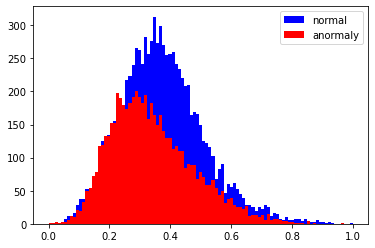

In [49]:
plt.hist(normal, bins=np.linspace(0.0, 1.0, num=100), color = 'b' , label = 'normal')
plt.hist(anormaly, bins=np.linspace(0.0, 1.0, num=100), color = 'r' , label = 'anormaly')
plt.legend()

plt.show()

## 테스트셋 이상감지 정확도(%) - 적절한 threshold에 따른 이상 감지율 계산

1. mean(normal)= 0.373872 2. mean(anormaly)= 0.34054154
3. std(normal)= 0.13718238 4. std(anormaly)= 0.1362585


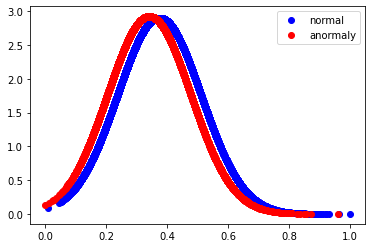

In [54]:
plt.plot(normal, norm.pdf(normal, np.mean(normal), np.std(normal)), 'o', color = 'b' , label='normal')
plt.plot(anormaly, norm.pdf(anormaly, np.mean(anormaly), np.std(anormaly)), 'o', color = 'r' , label='anormaly')
plt.legend()

print("1. mean(normal)=", np.mean(normal), "2. mean(anormaly)=",np.mean(anormaly))
print("3. std(normal)=", np.std(normal), "4. std(anormaly)=",np.std(anormaly))

## 이상감지 성공실패사례 제시

- CIFAR-10에서 특정 클래스, 6번 라벨 개구리(Frog)를 이상 데이터로 활용함
    1. 개구리(Frog) 6번 라벨링된 모든 이미지를 훈련 데이터에서 제거하고, 나머지 클래스로만 학습을 시킴
    2. 테스트 데이터를 6번 라벨(이상 데이터를 포함한) 형태로 구성하여 이상감지 성능을 평가하는 방식임
- 위 모델은 개구리는 학습되지 않은 데이터이므로, 테스트 데이터로 개구리가 나타나면 매우 특이한 상황이라고 가정하는 것임
    1. 위 시각화 자료에서 anormaly 데이터(6번 라벨)와 normal 데이터(나머지 라벨)간의 분포가 다른 것을 확인할 수 있음 